# AML Assignment 3

## Setup phase
- import the needed library
- set the seed for numpy and tensorflow backend

In [45]:
# remove pillow package

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.util import random_noise
from matplotlib import pyplot as plt
from livelossplot import PlotLossesKeras

np.random.seed(42)
tf.random.set_seed(42)

## Data preparation phase

In [46]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Model/data parameters
num_classes = 10
input_shape = (28,28,1)

# Scale images into the [0 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

60000 train samples
10000 test samples


Original image (class=2):


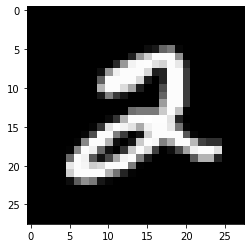

With gaussian noise:


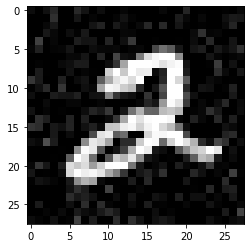

With s&p noise:


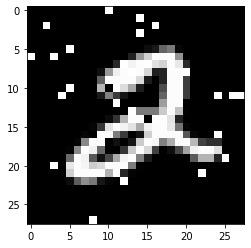

In [47]:
# First let's augment the dataset by adding new gaussian noised images
def add_noise(img, mode:str):
    noised_img = random_noise(image=img, mode=mode, seed=42, clip=True)
    return noised_img

# Visualize a noised image
print(f'Original image (class={y_train[5]}):')
plt.imshow(x_train[5]*255, cmap='gray')
plt.show()

print('With gaussian noise:')
plt.imshow(add_noise(x_train[5], 'gaussian')*255, cmap='gray')
plt.show()

print('With s&p noise:')
plt.imshow(add_noise(x_train[5], 's&p')*255, cmap='gray')
plt.show()

In [48]:
x_train_noised = []
y_train_noised = []
for i in range(0,x_train.shape[0]):
    imgs = [
        x_train[i], 
        add_noise(x_train[i], 'gaussian'), 
        add_noise(x_train[i], 's&p')
        ]
    labels = [y_train[i], y_train[i], y_train[i]]
    x_train_noised.extend(imgs)
    y_train_noised.extend(labels)
x_train_noised = np.array(x_train_noised)
y_train_noised = np.array(y_train_noised)

# Then shuffle it
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

shuffle_in_unison(x_train_noised, y_train_noised)

In [49]:
# Make images with size (28,28,1)
x_train_noised = np.expand_dims(x_train_noised, -1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train_noised.shape)
print(x_train_noised.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to bimnary class matrices
y_train_noised = keras.utils.to_categorical(y_train_noised, num_classes)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (180000, 28, 28, 1)
180000 train samples
10000 test samples


## Model definition

In [59]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Flatten(),        
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 6, 6, 32)          4640      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 2, 2, 32)          128       
_________________________________________________________________
dropout_33 (Dropout)         (None, 2, 2, 32)        

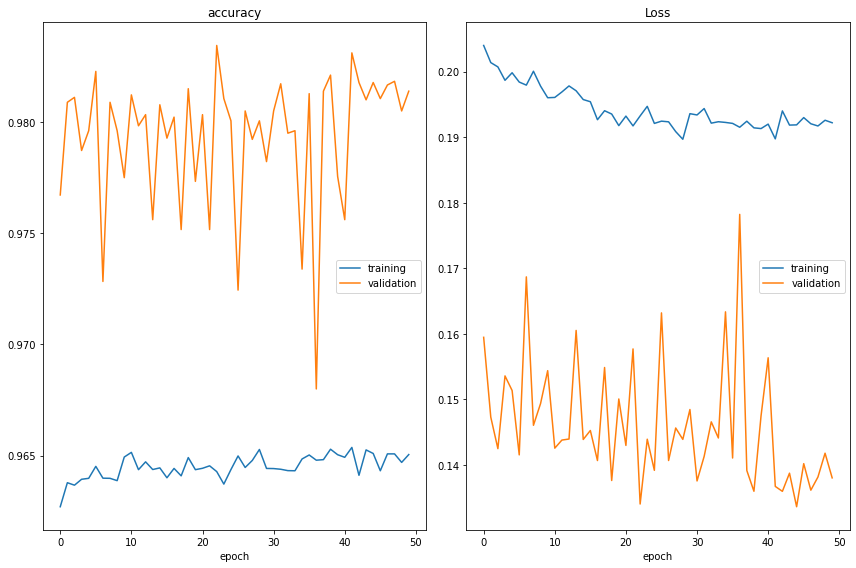

accuracy
	training         	 (min:    0.963, max:    0.965, cur:    0.965)
	validation       	 (min:    0.968, max:    0.983, cur:    0.981)
Loss
	training         	 (min:    0.190, max:    0.204, cur:    0.192)
	validation       	 (min:    0.134, max:    0.178, cur:    0.138)


In [61]:
batch_size = 32
epochs = 50
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(
    x_train_noised, 
    y_train_noised, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.1,
    verbose=0,
    callbacks=[PlotLossesKeras()])